In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import os
from os import path 
from time import time
import random

In [2]:
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "TRAS.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import django
django.setup()

from django.core.exceptions import ObjectDoesNotExist
from django.db import transaction
from django.conf import settings
from django_pandas.io import read_frame

from asgiref.sync import sync_to_async

from proto.models import Attraction, Review

In [3]:
from nltk.tokenize import RegexpTokenizer
from nltk import tokenize 
from nltk import Text
from nltk.corpus import stopwords

import nltk

In [4]:
retokenize = RegexpTokenizer("[\w]+")

In [5]:
query = Review.objects.all()
All_Reviews_df = read_frame(query)

In [15]:
All_Reviews_df.head().to_csv('Review_data_head.csv')

In [7]:
stop_words = set(stopwords.words('english')) 
stop_words = stop_words|set(['.', ',', 'the', "'s"])

In [8]:
lower_text =''.join(All_Reviews_df['text']).lower()

pre_token = retokenize.tokenize(lower_text)
token = [a_token for a_token in pre_token if a_token not in stop_words]

text = Text(token)
fd = text.vocab()

dict_5000 = {word:i for (word, i) in zip(fd, range(len(fd))) if i < 5000}

In [9]:
def pre_process(Reviews_df):
    star_list = list(Reviews_df['star'])
    text_list = list(Reviews_df['text'])
    
    result_text = []
    for text in text_list:
        tokens = retokenize.tokenize(text)
        processed_list = []
        for token in tokens:
            if token in dict_5000:
                processed_list.append(dict_5000[token])
        result_text.append(processed_list)
    
    result_star = []
    for star in star_list:
        if star >4:
            result_star.append(1)
        else:
            result_star.append(0)
        
    X = np.array(result_text)
    Y = np.array(result_star)
    return X, Y

In [10]:
X_head, Y_head = pre_process(All_Reviews_df[All_Reviews_df['star'] != 4].head())
print(X_head)
Y_head

[list([596, 2, 293, 809, 1652, 227, 246, 554, 727, 44])
 list([430, 23, 50, 1160, 1409, 2115, 150, 85, 575, 188])
 list([3, 642, 294, 18, 54, 9, 3, 44, 3364, 968])
 list([6, 13, 206, 87, 87, 2220, 20, 642, 294, 13, 2953, 410, 228])
 list([952, 416, 2403, 572, 524, 105, 42, 30, 67, 3496, 12, 63, 759, 1083, 21, 1376, 1198, 264, 81, 465, 665, 20, 277, 389, 367, 20, 570, 69])]


array([1, 1, 1, 1, 1])

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

In [12]:
X, Y = pre_process(All_Reviews_df[All_Reviews_df['star'] != 4])

In [14]:
X_padded = pad_sequences(X, maxlen=100)

from numpy import savetxt
# define data
# save to csv file
savetxt('X.csv', X_padded, delimiter=',')
savetxt('Y.csv', Y, delimiter=',')

리뷰의 최대 길이 : 503
리뷰의 평균 길이 : 28.336644014636697


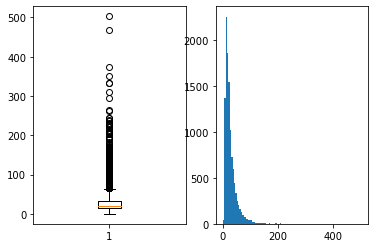

In [333]:
len_result = [len(s) for s in X]

print('리뷰의 최대 길이 : {}'.format(np.max(len_result)))
print('리뷰의 평균 길이 : {}'.format(np.mean(len_result)))

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=100)
plt.show()

In [302]:
from sklearn.model_selection import train_test_split

In [334]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

In [335]:
max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [336]:
model = Sequential()

# 단어를 읽어오는 세포 5천개

model.add(Embedding(5000, 120))
# 단어 하나마다 세포가 하나씩
# 단어들을 120개로 임베딩딩
model.add(Dropout(0.2))
# LSTM
model.add(LSTM(120))
model.add(Dropout(0.2))
#DropOut으로 랜덤으로 노드를 꺼줌으로서, 과적합을 방지

# 은닉층...
model.add(Dense(1, activation='sigmoid'))

In [337]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [338]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, callbacks=[es, mc])

Epoch 1/10
144/144 [==============================] - ETA: 0s - loss: 0.5136 - acc: 0.7623
Epoch 00001: val_acc improved from -inf to 0.79965, saving model to best_model.h5
144/144 [==============================] - 19s 131ms/step - loss: 0.5136 - acc: 0.7623 - val_loss: 0.4395 - val_acc: 0.7997
Epoch 2/10
144/144 [==============================] - ETA: 0s - loss: 0.3461 - acc: 0.8519
Epoch 00002: val_acc improved from 0.79965 to 0.80967, saving model to best_model.h5
144/144 [==============================] - 18s 126ms/step - loss: 0.3461 - acc: 0.8519 - val_loss: 0.4374 - val_acc: 0.8097
Epoch 3/10
144/144 [==============================] - ETA: 0s - loss: 0.2734 - acc: 0.8889
Epoch 00003: val_acc did not improve from 0.80967
144/144 [==============================] - 18s 126ms/step - loss: 0.2734 - acc: 0.8889 - val_loss: 0.4496 - val_acc: 0.8053
Epoch 4/10
144/144 [==============================] - ETA: 0s - loss: 0.2373 - acc: 0.9060
Epoch 00004: val_acc did not improve from 0.809

In [341]:
def top_low_n(name, n = 10):

    attraction_df = All_Reviews_df[All_Reviews_df['attraction']==name]['text']

    sentence_list = []
    for text in attraction_df:
        for sentence in tokenize.sent_tokenize(text):
            if len(sentence) > 15:
                sentence_list.append(sentence)
            
    result_sentences = []
    
    for sentence in sentence_list:
        tokens = retokenize.tokenize(sentence)
        processed_list = []
        for token in tokens:
            if token in dict_5000:
                processed_list.append(dict_5000[token])
        result_sentences.append(processed_list)

    X_sentence = np.array(result_sentences)
    X_sentence = pad_sequences(X_sentence, maxlen=max_len)

    prediction_list = model.predict(X_sentence)
    
    """
    for prediction in model.predict(X_sentence):
        max_i = 0
        max_value = 0
        for i, value in enumerate(prediction):
            if max_value < value:
                max_i = i
                max_value = value
        prediction_list.append(max_i)
    """

    sent_predict_df = pd.DataFrame([(sentence, prediction) for sentence, prediction in zip(sentence_list, prediction_list)]).sort_values(by = 1)
    
    print(name)
    print('negative')
    head = sent_predict_df.head(10)
    for star, sentence in zip(head[1], head[0]):
        print(star, " : ", sentence)
        
    print()
    print("positive")
    
    tail = sent_predict_df.tail(10)
    for star, sentence in zip(tail[1], tail[0]):
        print(star, " : ", sentence)

In [342]:
top_low_n("Gyeongbokgung Palace", n = 10)

Gyeongbokgung Palace
negative
[0.00825131]  :  It was destroyed during the Japanese invasion of 1592 and was reconstructed in 1867.During the Japanese Occupation between 1910 and 1945 most of the buildings were torn down and work continues to fully restore the place since 1990.
[0.01743782]  :  But in all these countries, for a while, the worst elements were in control.
[0.01856041]  :  If you ignore the whole place was rebuilt not long ago and hence isn't particularly original (although, of course, rebuilt in its impressive, historical, form) it is definitely worth seeing.
[0.0246284]  :  But it’s nothing compared to palaces in other countries.
[0.03219941]  :  We ended up renting hanbok (Korean old-style fancy clothing) before going into the palace which meant that we got free entry.
[0.03225231]  :  This Palace also houses the Korean National Palace Museum and the   National Folk Museum.Because it was the biggest remaining Korean palace , the whole complex was systematically destroy

In [312]:
data = """Lots of clothes , socks , bags , etc . neg
2
There 's an aquarium inside too which I was really tempted to go but I 'd just eaten a bunch of sushi and did n't need a reminder that I had probably eaten Nemo . neg
3
connects two hotels . neg
2
Definitely a must see ! pos
1
We accidentally came across this mall . neu
2
Do n't get confused , Quantity does not mean either Quality or a good price . neg
3
Do not forget your camera and the volunteers in costume are very happy to get a photo with you . pos
1
This area is great for the atmosphere , hotels , and variety of different kinds of restaurants and people you will find . pos
1
Overwhelmed by Korean youngers . pos
1
At a certain fee , they can prepare the seafood you bought from the market for you . neg
1
Be sure to reach earlier if you intend to visit the zoo and the various museums there since they close pretty early . neu
2
Fast , clean , and friendly staffs . pos
1
After getting familiarized we realized that there were so all Magic tour tickets available allowing to skip the line . neg
3
Other reviews have mentioned the interactive hands free headset . pos
1
A great way to thoroughly enjoy this palace is to emerge yourself into the culture ! pos
1
The street itself also quite artsy with some mural and street performance during night . pos
1
There are a lot of shops to choose from . pos
2
Again as before , go with a guide and this palace comes to life.Be prepared to walk , the treasure is the building architecture and the history . pos
1
This branch is the Main & Biggest one . neu
2
Even you can shop some cosmetics ( which is the same store that you can find in Myeongdong ! ) pos
1
There is an old building and a new building next to each other . pos
2
However I am disappointed towards Youll . neg
3
Here we share some day & night photos shot . neu
1
They will push you to buy fresh seafood and will bring you to a bunch of restaurants upstairs and charge you exorbitantly to cook it . neg
3
Was looking forward to coming here but after marvelling at the structure and sculptures outside we were a bit bemused by the inside . neg
3
Nice place . pos
1
Overall a very nice day trip in conjunction with a walk down to Independence Park . neu
1
It 's a residence area . neg
2
I 've never been in a library that is soo huge . pos
1
It was beautifully restored and displayed . neu
1
However , if you need to buy something inside the prices are extremely reasonable . neu
1
If this was all there was in the area then it would be great , but there are some very impressive “ competitors ” nearby . neg
2
The prices are not cheap though but we order 2 set menus consisting of about 10 items which cost about Kwn69,000/- . neu
3
When we got on the bus to go to the tower , I didn ’ t realize that it was at the top of a hill/mountain so I was surprised that we didn ’ t just walk , but I was thankful as we made our way up the windy roads that walking wasn ’ t happening ! pos
1
So if you want to know the other side of Seoul that is more interesting , just stay in Hongdae ! pos
1
Worth a visit ! pos
1
Queues were small to get up and down the tower though . neu
3
? The owner gave us a shopping bag and wrote our name in korean . neg
1
Main problem anywhere in Korea is the language barrier . neu
3
You can bargain with for price . neu
2
I forgot the name . neu
2
It 's a well-planned mall for a younger audience with many amenities for events such as the Seoul St. Patty 's Day festival . neu
1
Inside the Seoul metro area I think it is very competitive with cars and riding is generally as fast as driving.English is everywhere and am English speaker can easily use the metro , though specifics like express trains and branch line service can be hard to spot without a little Korean . neu
1
Small portions , so if you have a big appetite ... ... ? ? ? ? ? ? ? ? ? ? ? neu
3
They have a really interesting library in the middle of the COEX . pos
1
After a brief lesson , you use brush and ink to write the Hangeul word on canvas . pos
1
You can also check out the Hongdae Free Market on Saturdays . pos
1
You can see the whole of Seoul from up here . pos
1
There are 11 floors with top 3 of them dedicated to Duty Free shopping . pos
1
However , fee was charged for camel / pony riding , amusement park and character world.Upon entrance , we were greeted by the awesome autumn scenery with colorful orange , yellow and red leaves on the tall trees . neu
1
Well worth the $ 22 admission price . neu
1
This temple has so much more to offer than the more popular spots in Seoul.Gyeongbokgung Palace was just ... big , while the Temple was wonderfully ornate and less crowded . pos
1
The exhibits and exhibition style was interesting too . neu
1
This place is a quick walkthrough compared to other palaces in Seoul , but it 's worth a visit if you have been to the other palaces . neu
1
Lots of food affordable food available as well . neu
1
Goods sold here tend to be cheaper than what you can find in Meyongdong . neg
1
Nevertheless , the museum is a great chronology of Korean history told through wars . pos
1
The parking garage was cold.- I appreciated that they had us line up in order . neu
2
I think the best experience is to grab any street food you like and munch on them while shopping . pos
1
I definitely recommend the casino , but please note that it is a rather small facility and so finding a table can be very hard with the right limits ( unless you 're a high limits player ) . pos
1
There is a free museum under the statue that mentions Yi Sunshin one of Korea 's greatest heroes and other important exhibits about important dates in Korean history . pos
1
This is also near Pungmoon High School and Choong Ang High School where you can reminisce the drama : ) pos
1
Must do the tower and get a great view of the city . pos
1
It also started pissing it down raining . pos
2
Many shop and food have been changed to modern style but still you can find Korean special style . pos
1
There are several theaters that display either holograms or 3-D presentations . pos
1
Really enjoyed the enjoyed the gardens which this building is situated . pos
1
nice museum close to the gyongborksung palace . neu
1
But , you have to pay for 11,000 won to go up the observatory to see the whole country view . pos
3
He was suspected to die with a complication of diabetes . neu
2
They even have a museum at the top floor . neu
1
Do n't worry it so safe : ) pos
1
There are many trails to go to the top of the mountain . neu
2
No entrance fee at all.Boungeunsa Temple is a peaceful retreat that is nestled in the heart of one of the busiest location in Seoul . pos
1
The area is mostly full of ladies stuffs and other home decorations , accessories etc.. pos
1
Would recommend the greenbean pancake , gimbap and bibimbap there ! pos
1
There were a lot of police lined up at the street at that time , so it was interesting in that the old and the new were happening in one place . neu
1
The down side is , it 's mostly only in Korean ! neu
1
We were lucky as there was a traditional korean music performance on the palace grounds as well , so we got to experience that ? ? ? pos
1
The museum is very interested , especially considering that it focuses on modern history and economic development . neu
1
Created by the admiral , this vessel was the world 's best assault ship of the time . pos
1
Even u will find toilets , fitness pos
1
Thus the only option that I notice is sulbing bingsu shop or bring some snacks from the lotte mart outside . neg
3
If you like fresh and good quality seafood this is a total must ! pos
1
It does not disappoint ! pos
1
I also liberated a young man who had been locked in a cell by his ‘ friends ’ . neu
2
Especially if you want to watch a play with your lover , friend or family , and go to a nice and intimate restaurant for dinner , do n't hesitate to visit Daehakro . pos
1
! neg
2
It has a wide variety of artifacts including ancient ones . neg
1
Connect this tour with your geokbong palace tour . pos
2
Buy a shirt , support a team and hope that they win ! pos
1
The place is small and crowded . neg
3
While walking the ground of the shrine , I said to her “ ah-reum-dap-da ” which was to compliment it to be such a pretty and serene place . pos
1
Would n't recommend coming all the way for this . neg
3
I advise you not to visit Korea House unless you sleep on money . neg
3
You will find Bonghwadae ( beacon mound ) at the top as it was once the center of capital defense . pos
1
Good way to spend an hour . neu
1
I would recommend to visit during day time until 8 PM . pos
2
I just feel bad that all were enclosed ... neu
3
It 's just a gate as part of the larger Gyeongbokgung Palace . neu
2"""

In [345]:
h_test_list = []
sentence_of_n = ""
for line in data.split('\n'):
    try:
        tag_num = int(line)
        if tag_num == 1:
            tag = 1
        elif tag_num == 2:
            tag = 0.5
        else:
            tag = 0
        h_test_list.append((sentence_of_n, tag))
    except ValueError:
        sentence_of_n = line
h_test_list[:5]

[('Lots of clothes , socks , bags , etc . neg', 0.5),
 ("There 's an aquarium inside too which I was really tempted to go but I 'd just eaten a bunch of sushi and did n't need a reminder that I had probably eaten Nemo . neg",
  0),
 ('connects two hotels . neg', 0.5),
 ('Definitely a must see ! pos', 1),
 ('We accidentally came across this mall . neu', 0.5)]

In [347]:
result_sentences = []
h_list = []

for sentence, n in h_test_list:
    tokens = retokenize.tokenize(sentence)
    processed_list = []
    for token in tokens:
        if token in dict_5000:
            processed_list.append(dict_5000[token])
    result_sentences.append(processed_list)
    h_list.append(n)

X_sentence = np.array(result_sentences)
X_sentence = pad_sequences(X_sentence, maxlen=max_len)

prediction_list = model.predict(X_sentence)
"""
for prediction in model.predict(X_sentence):
    max_i = 0
    max_value = 0
    for i, value in enumerate(prediction):
        if max_value < value:
            max_i = i
            max_value = value
    prediction_list.append(max_i)
"""

'\nfor prediction in model.predict(X_sentence):\n    max_i = 0\n    max_value = 0\n    for i, value in enumerate(prediction):\n        if max_value < value:\n            max_i = i\n            max_value = value\n    prediction_list.append(max_i)\n'

In [353]:
residual_list = []
wrong = 0
nearly = 0
correct = 0

for h, p, S in zip(h_list, prediction_list, h_test_list):

    if abs(h-p) < 0.33:
        print("Correct!", h, p, S[0])
        correct += 1
    elif abs(h-p) <0.66:
        print("Nearly", h, p, S[0])
        nearly += 1
    
    else:
        print("Wrong...", h, p, S[0])
        wrong += 1

print('Correct : ', correct)
print('Nearly : ', nearly)
print('Wrong : ', wrong)
print('rate : ', (correct + nearly * 0.5) / (correct + wrong + nearly)) 

Correct! 0.5 [0.739873] Lots of clothes , socks , bags , etc . neg
Nearly 0 [0.4409516] There 's an aquarium inside too which I was really tempted to go but I 'd just eaten a bunch of sushi and did n't need a reminder that I had probably eaten Nemo . neg
Nearly 0.5 [0.11170006] connects two hotels . neg
Correct! 1 [0.70657164] Definitely a must see ! pos
Correct! 0.5 [0.5039751] We accidentally came across this mall . neu
Nearly 0 [0.62259066] Do n't get confused , Quantity does not mean either Quality or a good price . neg
Correct! 1 [0.99530464] Do not forget your camera and the volunteers in costume are very happy to get a photo with you . pos
Correct! 1 [0.99514747] This area is great for the atmosphere , hotels , and variety of different kinds of restaurants and people you will find . pos
Wrong... 1 [0.3368889] Overwhelmed by Korean youngers . pos
Correct! 1 [0.809152] At a certain fee , they can prepare the seafood you bought from the market for you . neg
Nearly 0.5 [0.9794143] B